In [2]:
import numpy as np
from numpy.linalg import inv
from scipy.stats import multivariate_normal
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Model

We are interested into determining the true position $p$ and velocity $v$ of a vehicle at time $t$ based on meausurements that are subject to random error. The observations are taken over fixed time interval; let $\Delta t$ denote difference between each pair of successive times of measurements. This model can be useful for various tasks such as determining the exact location and velocity at time $t$ and predicting their values at time $t+1$.

We assume the following model about the "true" posistion and velocity: 
$$
\left[\begin{array}{c}p_{t}\\v_{t}\end{array}\right] = \left[\begin{array}{cc}1 & \Delta t\\0 &1\end{array}\right]\left[\begin{array}{c}p_{t-\Delta t}\\v_{t-\Delta t}\end{array}\right] + \left[\begin{array}{c}\frac{1}{2}b \Delta t^2\\b\Delta t\end{array}\right]+\epsilon_t,
$$
where $b$ is a parameter reflecting acceleration, $\epsilon_t\sim N(0,Q)$ with $Q$ taken to be diagonal for simplicity.

Denoting $z=\left[\begin{array}{c}p_{t}\\v_{t}\end{array}\right]$, $A=\left[\begin{array}{cc}1 & \Delta t\\0 &1\end{array}\right]$ and $B=\left[\begin{array}{c}\frac{1}{2}b \Delta t^2\\b\Delta t\end{array}\right]$ and $u_t=1$, we can write the model for the hidden markov process as

$$
z_t = A z_{t-\Delta t} + B u_t +\epsilon_t
$$

Finally model for the noisy measurements $x$ of position and velocity is assumed to be

$$
x_t = z_t + \delta_t 
$$
where $\delta_t \sim N(0,R)$. For the notation in the slides this implies $C=I_2$, $D=0$.



### Prepare for the Kalman filter

In [ ]:
p_observations = np.array([4000, 4260, 4550, 4860, 5110])
v_observations = np.array([280, 282, 285, 286, 290])

x= np.c_[p_observations, v_observations]
[n,d] = x.shape

Dt = 1  # Difference in time
b = 2  # Acceleration

# Process / Estimation Errors
sigma_p = 20
sigma_v = 5

# Observation Errors - Uncertainty in the measurement  
omega_p = 25  #
omega_v = 6

#Kalman Filter Matrices needed for the recursions
A = np.array([[1, Dt],
                  [0, 1]])
B = np.array([0.5 * b* Dt ** 2, b*Dt])
u = 1
C = np.eye(d)
D = np.array([0,0])
Q = np.diag([sigma_p**2,sigma_v**2])
R = np.diag([omega_p**2,omega_v**2])
#z_prime = A.dot(X) + B.dot(u)

# Initial Conditions

v0 = 278
z0 = 3995
mu0 = np.array([z0,v0])
Sigma0 = Q

#Objects to store predictions and filtering locations
Mu = np.zeros((n,d))
Mupred = np.zeros((n,d))

### Run the Kalman filter

In [ ]:
mu = mu0
Sigma = Sigma0
logL = 0

for i in range(n):
    #observation for time i
    x = np.array([p_observations[i],v_observations[i]])

    #Prediction
    mu = A.dot(mu) + B.T.dot(u)
    Sigma  = A.dot(Sigma).dot(A.T)+Q
    Mupred[i,:] = mu
    
    #Kalman Gain
    S = C.dot(Sigma).dot(C.T) + R
    K = Sigma.dot(C).dot(inv(S))

    #Calculate log likelihood based on the i-th measurement
    M = C.dot(mu.T) +D.T.dot(u) 
    logL = logL + multivariate_normal.logpdf(x, mean=M, cov=S)
    
    # Correction
    mu = mu + K.dot(x- C.dot(mu)- D*u )
    Sigma = (np.identity(d) - K.dot(C)).dot(Sigma)
    Mu[i,:] = mu    
    
print("Kalman Filter log likelihood:\n", logL)

In [ ]:
t=range(n)
plt.plot(t,p_observations,'o',label='observed')
plt.plot(t,Mupred[:,0],'o',label='predicted')
plt.plot(t,Mu[:,0],'o',label='filtered')
plt.legend()

### Activity

Simulate $50$ points from the following model 
$$
z_t=0.8 z_{t-1}+0.5+\epsilon_t,\;\;\;\;\epsilon_t\sim N(0,1),
$$
$$
x_t= z_t+\delta_t,\;\;\;\;\delta_t\sim N(0,0.5^2),
$$
where $t=0,1,\dots,50$ and $z_0=0$.
Run the Kalman filter on the simulated data and plot the predicted and filtered paths overlaid on the observed data as well as the 'true' $z$ values, i.e. the values you simulated above.

Put your code below:

In [40]:
# Simulate the data
n=50
z = np.zeros(n+1)
x = np.zeros(n+1)
x[0] = z[0]+np.random.randn(1)
for i in range(n):
    z[i+1] = 0.8*z[i]+0.5+np.random.randn(1)
    x[i+1] = z[i+1]+0.5*np.random.randn(1)

In [50]:
# Prepare the Kalman filter

# Kalman filter matrices
A = 0.8
B = 0.5
C = 1
D = 0
u = 1
Q = 1
R = 0.5**2

# Initial Conditions
z0 = 0
mu0 = 0
Sigma0 = Q

#Objects to store predictions and filtering locations
Mu = np.zeros(n+1)
Mupred = np.zeros(n+1)

In [51]:
mu = mu0
Sigma = Sigma0
logL = 0

for i in range(n):

    #Prediction
    mu = A*mu + B*u
    Sigma  = A*Sigma*A+Q
    Mupred[i] = mu
    
    #Kalman Gain
    S = C*Sigma*C + R
    K = Sigma*C/S

    #Calculate log likelihood based on the i-th measurement
    M = C*mu + D*u 
    logL = logL + multivariate_normal.logpdf(x[i], mean=M, cov=S)
    
    # Correction
    mu = mu + K*(x[i]- C*mu- D*u )
    Sigma = (1 - K*C)*Sigma
    Mu[i] = mu    
    
print("Kalman Filter log likelihood:\n", logL)

Kalman Filter log likelihood:
 -78.66437037298174


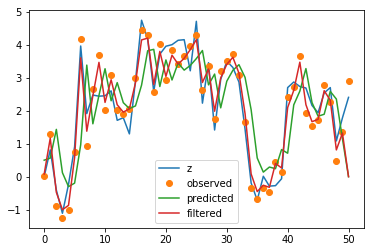

In [52]:
t=range(n+1)
plt.plot(t,z,label='z')
plt.plot(t,x,'o',label='observed')
plt.plot(t,Mupred,label='predicted')
plt.plot(t,Mu,label='filtered')
plt.legend()

### Bob Alice Example of Hidden Markov Models

In [ ]:
states = ('Rainy', 'Sunny')
observations = ('walk', 'shop', 'clean')
pi = np.array([0.6, 0.4])  #initial probability 
A = np.array([[0.7, 0.3],[0.4, 0.6]]) #Transmission probability 
B = np.array([[0.1, 0.4, 0.5],[0.6, 0.3, 0.1]]) #Emission probability
bob_says = np.array([0, 2, 1, 1, 2, 0, 1,2,1,0,0,2,1])
print(bob_says)

### Forward Algorithm

In [ ]:
def forward(obs_seq, pi, A, B):
    T = len(obs_seq)
    N = A.shape[0]
    alpha = np.zeros((T, N))
    alpha[0] = pi*B[:,obs_seq[0]]
    for t in range(1, T):
        alpha[t] = np.inner(alpha[t-1],A) * B[:, obs_seq[t]]
    return alpha

def likelihood(alpha):
    # returns log P(Y  \mid  model)
    # using the forward part of the forward-backward algorithm
    return  alpha[-1].sum()

In [ ]:
alpha = forward(bob_says, pi, A, B)
print(alpha)

In [ ]:
likelihood(alpha)

### Forward Backward Algorithm

In [ ]:
def backward(obs_seq, A, B):
    N = A.shape[0]
    T = len(obs_seq)

    beta = np.zeros((N,T))
    beta[:,-1:] = 1

    for t in reversed(range(T-1)):
        for n in range(N):
            beta[n,t] = np.sum(beta[:,t+1] * A[n,:] * B[:, obs_seq[t+1]])

    return beta

def fb(alpha, beta):
    obs_prob = likelihood(alpha)
    return (np.multiply(alpha,beta.T) / obs_prob)

In [ ]:
beta=backward(bob_says, A, B)
gamma=fb(alpha, beta)
print('beta',beta.T)
print('gamma',gamma)

In [ ]:
def viterbi(obs_seq,pi, A, B):
    # returns the most likely state sequence given observed sequence x
    # using the Viterbi algorithm
    T = len(obs_seq)
    N = A.shape[0]
    delta = np.zeros((T, N))
    psi = np.zeros((T, N))
    delta[0] = pi*B[:,obs_seq[0]]
    for t in range(1, T):
        for j in range(N):
            delta[t,j] = np.max(delta[t-1]*A[:,j]) * B[j, obs_seq[t]]
            psi[t,j] = np.argmax(delta[t-1]*A[:,j])

    # backtrack
    states = np.zeros(T, dtype=np.int32)
    states[T-1] = np.argmax(delta[T-1])
    for t in range(T-2, -1, -1):
        states[t] = psi[t+1, states[t+1]]
    return states

In [ ]:
alice_infers=viterbi(bob_says, pi, A, B)
names = ['Bob says','Alice infers']
BS = list(map(lambda y: observations[y], bob_says))
AI = list(map(lambda s: states[s], alice_infers))

best_path = pd.DataFrame(np.column_stack([BS,AI]),columns=names)
best_path
#print("Bob says:", ", ",list(map(lambda y: observations[y], bob_says)))
#print("Alice infers:", ", ", list(map(lambda s: states[s], alice_infers)))